League of Legends is a popular Multiplayer Online Battle Arena (MOBA) that is played by more than 100 Million people around the globe. Data is publicly available and can be accessed. The problem is that the data structure is very incovenient (a lot of dictionaries) and a lot of data wrangling is necessary until actual, useful questions can be answered. This project gets data from the Riot Games API.

In [470]:
import pandas as pd
import numpy as np
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, no_update

Teams try to find talented players. We want to get stats for the best players (Rank: Challenger) of the Korean server. Teams' scouts might be interested in metrics.


Reading in data from Oracle's Elixir, downloaded on 1-13-2021.

In [471]:
sp_2021_reg, sp_2021_pl, su_2021_reg, su_2021_pl =  pd.read_csv("LCK CL 2021 Spring - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Spring Playoffs - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Summer - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Summer Playoffs - Player Stats - OraclesElixir.csv")

all_splits = [sp_2021_reg, sp_2021_pl, su_2021_reg, su_2021_pl]

all_splits_df = pd.concat(all_splits)

Inspecting one players as an example.

In [472]:
all_splits_df.query('Player == "Berserker"').columns

Index(['Player', 'Team', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'STL', 'WPM', 'WCPM'],
      dtype='object')

We want to change some column names to avoid confusion.

In [473]:
all_splits_df = all_splits_df.rename(columns={"K": "total_kills",
"Pos": "position",
 "D": "total_deaths",
  "A": "total_assists",
  "GP": "games_played",
   "W%": "winrate%",
    "CTR%": "pick_after_opponent%",
     "KP":"kill_assist_participation%",
      "KS%":"kill_participation%",
      "DTH%":"average_share_teams_deaths%",
      "FB%": "first_blood_participation_rate%",
      "GD10": "average_gold_diff_10_min",
      "XPD10": "average_xp_diff_10_min",
      "CSD10": "average_cs_diff_10_min",
      "CSPM": "average_CSPM",
      "CS%P15": "average_share_team_cs_post_15_min%",
      "DPM": "average_DPM_to_champs",
      "DMG%": "average_share_team_DMG_to_champs%",
      "D%P15": "average_share_team_DMG_to_champs_post_15_min%",
      "EGPM": "average_gold_per_min",
      "GOLD%": "average_share_team_gold%",
      "STL": "num_neutral_obj_stolen",
      "WPM": "average_wards_per_min",
      "WCPM": "average_wards_cleared_per_min"})

Inspecting the resulting column names and their datatypes. 

In [474]:
all_splits_df.dtypes

Player                                            object
Team                                              object
position                                          object
games_played                                       int64
winrate%                                          object
pick_after_opponent%                              object
total_kills                                        int64
total_deaths                                       int64
total_assists                                      int64
KDA                                              float64
kill_assist_participation%                        object
kill_participation%                               object
average_share_teams_deaths%                       object
first_blood_participation_rate%                   object
average_gold_diff_10_min                           int64
average_xp_diff_10_min                             int64
average_cs_diff_10_min                           float64
average_CSPM                   

All columns that are measured in percent are not recognized as numeric columns, but as object columns. In order to use mathematical operations with these columns, they have to be transformed to numeric columns.

In [475]:
all_splits_df['winrate%'].str.rstrip('%')

#all_splits_df.astype({'winrate%' : 'float64'})

0     55
1     83
2     63
3     83
4     42
      ..
28    40
29    40
30    44
31    50
32    50
Name: winrate%, Length: 195, dtype: object

As we have seen above, some players participated in more than one split, we have to aggregate their data, such that we end up with one row for every player. We want to keep non-performance related features, as they are in the raw data: this includes the player name, his team, his position and the number of games played. Some metrics allow for just averaging over them (e.g. all averaged metrics). This is possible, as these metrics refer to an average game of a player in one split, i.e. playoff. Thus, taking their mean just means that the value now represents the average game of all tournaments, a player took part in. However, this can not be done for absolute measures who refer to a whole tournaments, such as kills. This is due to the fact that certain players have participated in different tournaments that had a different amount of games. This questions the general use of absolute measures.

We are gonna create lists that specify columns that will be aggregated in the same way: one list for the columns that will be summed, one list for the columns that will be averaged, and finally, one list for the remaining, non-numerical, columns.

In [476]:
cols_to_sum = ['games_played',
 'total_kills', 'total_deaths',
  'total_assists', 'num_neutral_obj_stolen']

cols_to_keep = ['Player','Team', 'position']

cols_to_avg = [col for col in all_splits_df.columns if col not in (cols_to_sum + cols_to_keep)]

Transforming string columns that are stored in % to numerical columns, before grouping and performing the aggregation.

In [477]:
percentage_cols = [col for col in cols_to_avg if col.endswith("%")]

all_splits_df_percentage_cols = all_splits_df[percentage_cols].astype(str).applymap(lambda x: x.strip("%"))



all_splits_df = pd.concat([all_splits_df.drop(percentage_cols, axis = 1),
 all_splits_df_percentage_cols.astype('float16')], axis = 1)

In [478]:
all_splits_df.dtypes

Player                                            object
Team                                              object
position                                          object
games_played                                       int64
total_kills                                        int64
total_deaths                                       int64
total_assists                                      int64
KDA                                              float64
average_gold_diff_10_min                           int64
average_xp_diff_10_min                             int64
average_cs_diff_10_min                           float64
average_CSPM                                     float64
average_DPM_to_champs                              int64
average_gold_per_min                               int64
num_neutral_obj_stolen                           float64
average_wards_per_min                            float64
average_wards_cleared_per_min                    float64
winrate%                       

Grouping and aggregating.

In [479]:
all_splits_by_player = all_splits_df.groupby(['Player'])

orig_cols = all_splits_df[cols_to_keep].drop_duplicates('Player')
summed_cols = all_splits_by_player[cols_to_sum].sum()


avg_cols = all_splits_by_player[cols_to_avg].mean()



 Concatenating the dfs and dropping players that have played 10 games or less, as there are outliers.

In [480]:
orig_summed_cols = pd.concat([orig_cols.set_index('Player'), summed_cols], axis = 1)
agg_all = pd.concat([orig_summed_cols, avg_cols], axis = 1).query('games_played >= 10')

Unfortunately, the metrics are still biased by the team and the position of a player. One should not compare the number of kills of a support and of an attack damage carry (ADC). This can be easily be taken care of by grouping by positions.
Added to that, two players that feature the same characteristics (e.g. ability) will have different metrics. This is due to the fact that if one player is on the worst team, while the other is on the best team, he will score less kills, for example. Therefore, it is also indispensable to account for the relative rank of a player's team. In order to minimize the team's effect, we will conduct statistical tests to compare the performance of teams. Then, if a team's performance (m games won out of n games) is not statistically different from another team's, we consider then to be similar, allowing for comparison of players. First, we have to compute a team's performance. This can be done by looking at the player of the team that has played most games for it, serving as an estimate for m and n.

In [481]:
teams = agg_all.groupby(['Team']).max('games_played')

teams = teams.assign(wins = (teams['winrate%'] / 100) * teams['games_played']).astype(int)

win_stats = teams[['wins', 'winrate%', 'games_played']].sort_values(by=['winrate%'], ascending = False)

win_stats

,wins,winrate%,games_played
Team,,,
Gen.G Challengers,39,76,51
T1 Challengers,29,70,42
Nongshim RedForce Challengers,28,59,48
Kwangdong Freecs Challengers,21,58,36
DWG KIA Challengers,19,54,36
Hanwha Life Esports Challengers,26,52,50
DRX Challengers,24,50,48
KT Rolster Challengers,23,48,48
Liiv SANDBOX Challengers,21,47,46


By descriptively looking at the teams, I would suggest three groups: Gen.G, DWG, Freecs and T1 form the best teams, followed by mid tier teams Nongshim and KT. Lastly, we have the rest of the teams whose winrate is very close to 50% only. Unfortunately, comparison within groups would be quite difficult, assuming we have three groups, as in the worst case scenario, we would only have two players in each position to compare in the mid tier group. Therefore, two groups should be the play. Still, it remains unclear, where the cut-off should be. Maybe inference can help us making this decision: 

#### Hypothesis testing
$H_0: w_0 = ... = w_9 $

A standard testing procedure comparing all win rates, simultaneously, would not really help to solve to this problem, as it is super likely that we would reject the $H_0$ just due to Fredit and Gen.G's difference. We would not gain a lot of additional insight, as we don't statistical evidence for this difference (the worst team and the best team are just different). Therefore, it is necessary to think about a more useful approach. It would be possible to do pair wise comparisons instead. Then, however, one has to consider the type-1-error inflation, by implementing, for instance, the Bonferroni correction. \
Pair-wise comparisons can be done by doing Binomial tests, as we are having one binomial distribution for every team. We want to know whether these distributions differ.

$p(w_i | m_i , n_i ) =  \frac{p(m_i , n_i | w_i) * p(w_i)}
    {\int p(m_i , n_i | w_a) * p(w_a) dw_a}$

Let's do Bayesian inference to get a posterior for the winrate of every team. The prior should be a distribution that suggests, most frequently, a winrate of 50%, as I would assume, before seeing any data that each team will perform similarly well, while some teams are worse and some teams are better. We want to use a Beta prior:

$p(w_i) = \frac{(w_i)^{a-1} (1-w_i)^{b-1}}{B(a,b)}$

Creating a function that plots a beta distribution, which is parameterized by a and b:

In [482]:
def plot_beta_prior(a:float, b:float):

    prior = beta(a,b)

    mm = np.linspace(0, 1, 500)

    fig,ax = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    
    ax.vlines(mm,0,prior.pdf(mm))   



A symmetric beta distribution manifests the belief that the most frequent winrate is 50%:

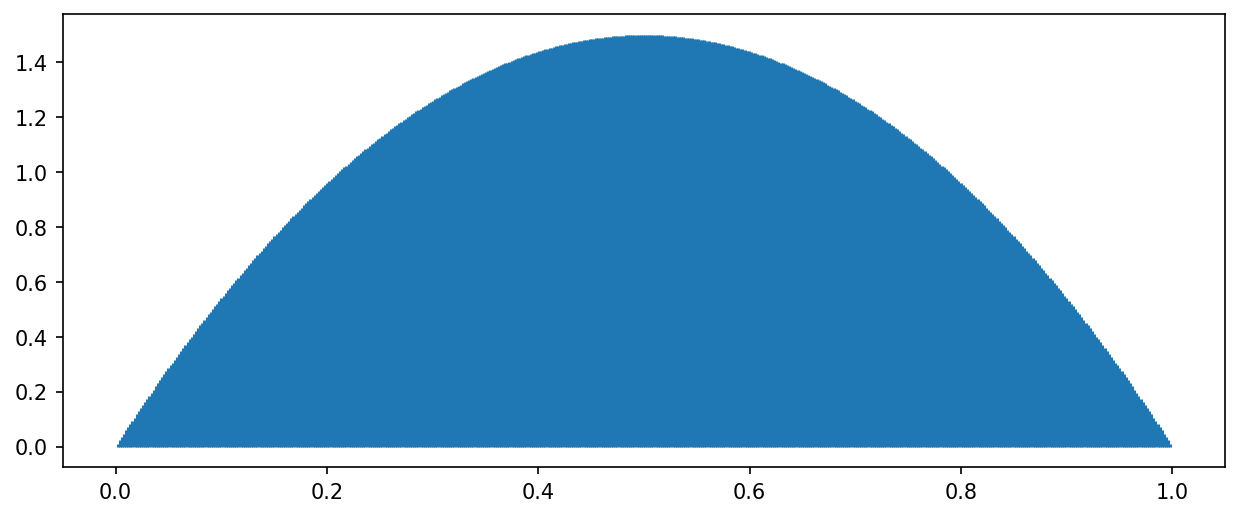

In [483]:
plot_beta_prior(2,2 )

As mentioned above, we are having a Binomial likelihood:

$p(m_i , n_i | w_i) = {n_i\choose m_i} w_{i}^{m_i} (1 - w_i)^{n_i - m_i}$

Creating a function that plots a binomial distribution:

In [484]:
def plot_binomial_likelihood(n:int, w:float):

    grid = np.arange(n_1)

    fig,ax = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    ax.vlines(grid, 0, binom.pmf(grid, n, w))   


For Gen.G, this looks like:

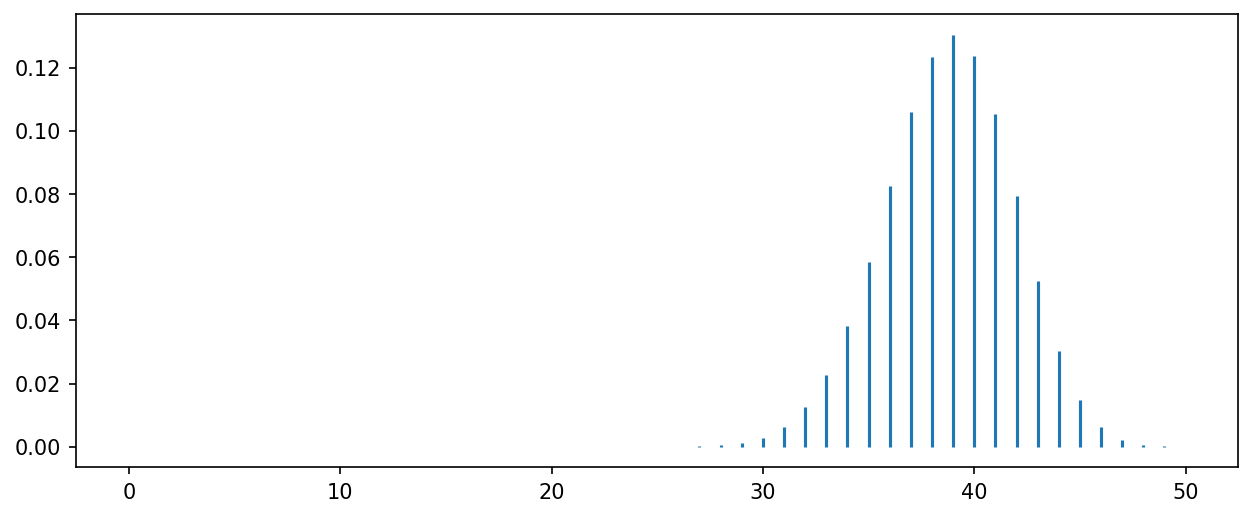

In [485]:
n_1 = win_stats.loc['Gen.G Challengers'].games_played
w_1 = win_stats.loc['Gen.G Challengers'][['winrate%']]/100
m_1 = win_stats.loc['Gen.G Challengers'].wins

plot_binomial_likelihood(n_1, w_1)


The Beta distribution is a conjugate prior for the Binomial distribution, which means that we can write down the posterior in the following closed form:

$p(w_i | m_i , n_i ) = \frac{(w_i)^{a - 1 + m_i} (1-w_i)^{b- 1+ n_i - m_i}}{B(a + m_i; b - n_i + m_i )}$

Creating a function that plots the probability density function (PDF) of a posterior (beta distribution), which is parameterized by $a' = a + m_i$ and $b' = b - n_i + m_i$:

In [486]:
def plot_beta_posterior_team(teams:list, a:int, b:int):
    """
    Specify a list of teams whose posterior should plotted,
    assuming prior Beta prior parameters a and b.

    """
    jet= plt.get_cmap('jet')
    colors = iter(jet(np.linspace(0,1,5)))
    
    fig, axs = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    
    for team in range(len(teams)):
        m_i = win_stats_formalized.filter(like=teams[team], axis=0).m_i
        n_i = win_stats_formalized.filter(like=teams[team], axis=0).n_i 

        mm = np.linspace(0, 1, 100)
        
        axs.plot(mm, beta.pdf(mm, a + m_i, b + n_i - m_i ), label=teams[team])
        axs.fill(mm, beta.pdf(mm, a + m_i, b + n_i - m_i ), alpha = 0.2)
        axs.legend()

        

In [487]:
win_stats_formalized = win_stats.rename(columns={"wins": "m_i", "winrate%": "w_i", "games_played": "n_i"})

win_stats_formalized

,m_i,w_i,n_i
Team,,,
Gen.G Challengers,39,76,51
T1 Challengers,29,70,42
Nongshim RedForce Challengers,28,59,48
Kwangdong Freecs Challengers,21,58,36
DWG KIA Challengers,19,54,36
Hanwha Life Esports Challengers,26,52,50
DRX Challengers,24,50,48
KT Rolster Challengers,23,48,48
Liiv SANDBOX Challengers,21,47,46


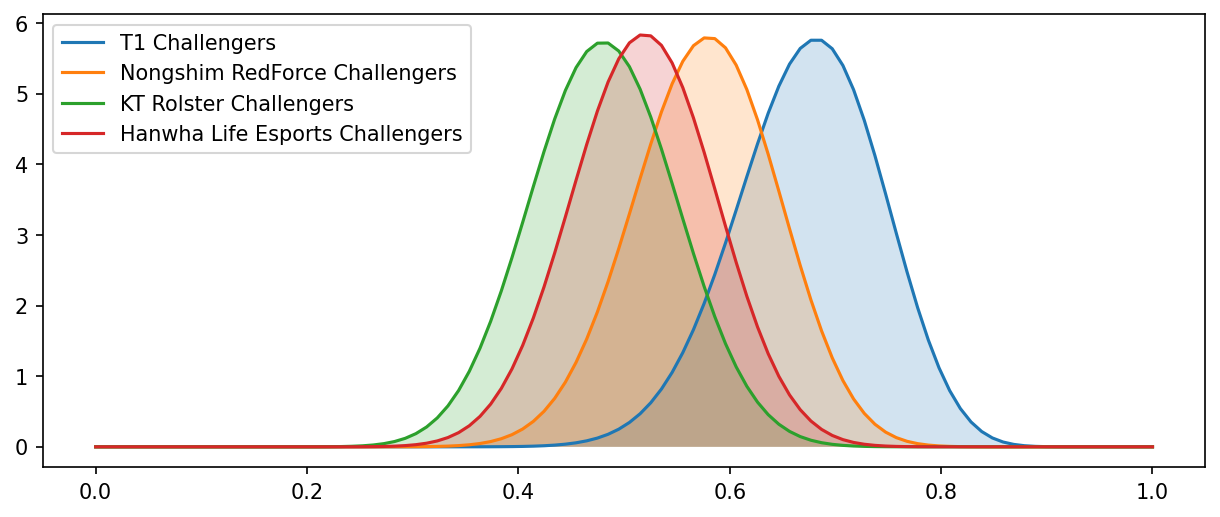

In [488]:
teams = ['T1 Challengers', 'Nongshim RedForce Challengers', 'KT Rolster Challengers',
'Hanwha Life Esports Challengers']

plot_beta_posterior_team(teams, 2, 2)

The posterior plots question the whole idea of splitting the data in groups. I have to admit that it also does not make a lot of sense. Later, in the notebook we will see that players have, independent of their team, a huge difference in winrates.
Other than that, the analyst could also focus on metrics that show the team's fraction. Like that, we could check for the following hypotheses:

- who is the most efficient player: who does most damage / yields highest KDA by needing the least amount of resources (gold / xp). Let us call these metrics gold efficiency. Like in soccer, goals are not everything, but having the top scorer of the league on your team definitely helps winning. First of all, damage and kill participation are clearly not the relevant metrics in every game. There are many scenarios that we can think off: for instance, it might be that a player performs horribly (low total damage, low KP) and just ends up playing one teamfight perfectly that wins the game for his team. Of course, at first glance, that player seemed to have made the difference, but if it wasn't for his teammates, who maybe consistently perform well, the team maybe would not have even been in the position, where he could shine. Nevertheless, on average, stakeholders should consider a player an extraordinary good player, who is able to consistently, on average, performing relatively well. 

- who is the best inlane: who performs well in terms of cs and xp, even though he does, potentially, counterpicked. In the early game (pre 10 minutes), the team influence is limited, as laners are mostly in isolated matchups.

To account for the bias in the KPIs (an ADC will deal more damage than a support) caused by positions, the data should be grouped by the position of the player. Or put everything in one plot and mark positions.

In [489]:
agg_all.position

5kid             ADC
Asper        Support
Baut         Support
Berserker        ADC
Bini             ADC
              ...   
Willer        Jungle
SOLKA         Middle
TaNa             Top
Pleata       Support
Bible        Support
Name: position, Length: 71, dtype: object

In [490]:
Middle = agg_all.query('position == "Middle"')

Middle[['KDA', 'total_kills', 'total_deaths', 'total_assists']].assign(KDA_custom =
 (Middle['total_kills'] + Middle['total_assists'])/Middle['total_deaths'])

,KDA,total_kills,total_deaths,total_assists,KDA_custom
Dice,3.500000,47,34,75,3.588235
Eign,2.633333,108,115,211,2.773913
FIESTA,2.433333,80,99,176,2.585859
Jool,3.050000,69,90,184,2.811111
Keine,3.433333,89,64,132,3.453125
Mask,4.200000,144,105,292,4.152381
Mireu,4.100000,149,124,300,3.620968
Ophelia,3.866667,56,50,156,4.240000
Roamer,4.100000,131,97,267,4.103093
TolanD,3.100000,114,120,283,3.308333


In [491]:
Middle.columns

Index(['Team', 'position', 'games_played', 'total_kills', 'total_deaths',
       'total_assists', 'num_neutral_obj_stolen', 'winrate%',
       'pick_after_opponent%', 'KDA', 'kill_assist_participation%',
       'kill_participation%', 'average_share_teams_deaths%',
       'first_blood_participation_rate%', 'average_gold_diff_10_min',
       'average_xp_diff_10_min', 'average_cs_diff_10_min', 'average_CSPM',
       'average_share_team_cs_post_15_min%', 'average_DPM_to_champs',
       'average_share_team_DMG_to_champs%',
       'average_share_team_DMG_to_champs_post_15_min%', 'average_gold_per_min',
       'average_share_team_gold%', 'average_wards_per_min',
       'average_wards_cleared_per_min'],
      dtype='object')

In [492]:
Middle[['kill_assist_participation%', 'average_share_teams_deaths%']]

,kill_assist_participation%,average_share_teams_deaths%
Dice,64.37500,24.593750
Eign,61.96875,20.437500
FIESTA,77.75000,17.031250
Jool,68.25000,18.796875
Keine,68.12500,18.734375
Mask,70.37500,16.437500
Mireu,71.87500,24.703125
Ophelia,65.50000,17.531250
Roamer,75.06250,17.796875
TolanD,68.93750,21.718750


General gold efficiency. Multiply by fraction of maximum amount of games played in that position to account for the uncertainty by less games played. Or adjust thickness of scatter points (the thicker, the more games played). 

In [493]:
agg_all = agg_all.assign(DPM_per_gold = agg_all['average_share_team_DMG_to_champs%']/agg_all['average_share_team_gold%'])
agg_all = agg_all.assign(Net_KP_per_gold = (agg_all['kill_assist_participation%'] - agg_all['average_share_teams_deaths%']) /agg_all['average_share_team_gold%'])


### Creating early game performance metrics

In the early game, i.e. in the first 10 minutes of the game, the team's influence is rather limited, as most matchups are isolated. Of course, early plays happen. Let's assume that independently of the team, these events have the same probability for every team, which means that we can disregard it. Added to that, beside the first dragon, no neutral objectives, except for jungle camps, are available. Therefore, it can be concluded that accumulating resources can not be associated with high opportunity cost. 

It suffices to look at the gold and the xp diff, as the cs is just one cause of these differences. Yet, in pro play, they could be greatly influenced by who in the matchup gets the counterpick. Thus, let's normalize the average gold and xp differences by the amount of games, where a player had a chance to pick his champion after his opponent, indicating a potential counterpick:


$GD^*  =  \frac{gdiff}{counter\%} $

$XPD^* =  \frac{xpdiff}{counter\%} $

In [494]:
agg_all = agg_all.assign(early_gold_diff_per_counter_percentage = agg_all['average_gold_diff_10_min'] / agg_all['pick_after_opponent%'],
early_xp_diff_per_counter_percentage = agg_all['average_xp_diff_10_min'] / agg_all['pick_after_opponent%'])

Let us know compute a rank for each metric and average over them to compute the top performers. This has to be done for each group (position):

In [498]:
per_position = agg_all.groupby('position')
per_position['DPM_per_gold_rank'] = per_position[['DPM_per_gold']].rank(ascending=False)

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [442]:


agg_all['DPM_per_gold_rank'] = agg_all[['DPM_per_gold']].rank(ascending=False).sort_values('DPM_per_gold')
agg_all['Net_KP_per_gold_rank'] = agg_all[['Net_KP_per_gold']].rank(ascending=False).sort_values('Net_KP_per_gold')
agg_all['early_gold_diff_per_counter_percentage_rank'] = agg_all[['early_gold_diff_per_counter_percentage']].rank(ascending=False).sort_values('early_gold_diff_per_counter_percentage')
agg_all['early_xp_diff_per_counter_percentage_rank'] = agg_all[['early_xp_diff_per_counter_percentage']].rank(ascending=False).sort_values('early_xp_diff_per_counter_percentage')
agg_all['average_metric_rank'] = agg_all[['DPM_per_gold_rank',
 'Net_KP_per_gold_rank',
  'early_gold_diff_per_counter_percentage_rank',
   'early_xp_diff_per_counter_percentage_rank']].mean(axis=1)

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [443]:
agg_all

In [410]:
agg_all[['DPM_per_gold_rank', 'early_gold_diff_per_counter_percentage_rank', 'average_metric_rank']].loc["Chasy"]

DPM_per_gold_rank                               1.00
early_gold_diff_per_counter_percentage_rank     1.00
average_metric_rank                            15.75
Name: Chasy, dtype: float64

In [388]:
agg_all[['DPM_per_gold', 'Net_KP_per_gold', 'early_gold_diff_per_counter_percentage', 'early_xp_diff_per_counter_percentage']]

,DPM_per_gold,Net_KP_per_gold,early_gold_diff_per_counter_percentage,early_xp_diff_per_counter_percentage
5kid,1.049805,1.834961,1.360015,0.786735
Asper,0.832031,5.011719,-2.013333,-0.713333
Baut,0.794922,5.351562,0.233084,-0.128810
Berserker,1.025391,1.974609,3.763889,3.527778
Bini,0.995605,2.066406,-3.737288,-4.101695
...,...,...,...,...
Willer,0.924805,2.802734,-2.660000,2.540000
SOLKA,0.977539,2.095703,3.845455,2.254545
TaNa,0.925781,1.700195,-3.075000,-3.800000
Pleata,1.087891,6.628906,-0.947368,4.052632


### Create plots

Define team logo urls

In [356]:
t1_img = pd.Series('https://cdn1.dotesports.com/wp-content/uploads/2019/10/08064645/image-7.png')
kt_img = pd.Series('https://scontent-frt3-1.xx.fbcdn.net/v/t1.18169-9/12729350_1291829277510939_5501539112801543611_n.png?_nc_cat=107&ccb=1-5&_nc_sid=973b4a&_nc_ohc=sOjAVFCJPhYAX99tkzC&_nc_ht=scontent-frt3-1.xx&oh=00_AT-ZOo1WcpOGTP2gvDxcc1JRhuqlw-GtTMGdG_HsvTk3kw&oe=622282B6')
nonghshim_img = pd.Series('https://pbs.twimg.com/profile_images/1397150687427895299/v0aDiUPe_400x400.jpg')
drx_img = pd.Series('https://api.sofascore.com/api/v1/team/364017/image')
dwg_img = pd.Series('https://static.invenglobal.com/upload/image/2021/01/26/o1611641144974891.jpeg')
gen_img = pd.Series('https://cdn0.gamesports.net/edb_team_logos/24000/24147.png?1608560414')
fred_img = pd.Series('https://api.sofascore.app/api/v1/team/372615/image')
hanwha_img = pd.Series('https://api.sofascore.com/api/v1/team/364492/image')
kwang_img = pd.Series('https://api.sofascore.app/api/v1/team/405273/image')
sand_img = pd.Series('https://cdn1.dotesports.com/wp-content/uploads/2021/02/15173303/geng.png')

logos = pd.concat([kt_img, t1_img, hanwha_img, fred_img, nonghshim_img, kwang_img, dwg_img, drx_img, sand_img, gen_img])



teams = pd.unique(agg_all[['Team']].values.ravel())
teams_logos = pd.DataFrame({'Team': teams, 'Image_SRC': logos})

agg_all = agg_all.rename_axis('Player').reset_index().merge(teams_logos, how = 'inner', on = ['Team'])

In [357]:
# Create basic fig
resource_diff_no_dash_fig = px.scatter(agg_all, x="early_gold_diff_per_counter_percentage", y="early_xp_diff_per_counter_percentage",
hover_name = "Player", hover_data=["Team", "games_played", "winrate%", "DPM_per_gold",
"Net_KP_per_gold"], size = "games_played",
facet_col='position', color = 'position', facet_col_wrap = 3,
category_orders = {"position": ["Top", "Jungle", "Middle", "ADC", "Support"]})


resource_diff_no_dash_fig.update_layout(title_text = 'Average resource differences at minute 10: the bigger the circle, the more games played', title_x = 0.5)
resource_diff_no_dash_fig.update_traces(marker=dict(symbol='circle-dot'), line=dict(width=2, color='Black'))
resource_diff_no_dash_fig.update_xaxes(matches=None)
resource_diff_no_dash_fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
resource_diff_no_dash_fig.update_yaxes(matches=None)
resource_diff_no_dash_fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

resource_diff_no_dash_fig.show()

Gold efficiency plot for the paper (no image hover)

In [358]:
# Create basic fig
Gold_effciency_no_dash_fig = px.scatter(agg_all, x="DPM_per_gold", y="Net_KP_per_gold",
hover_name = "Player", hover_data=["Team", "games_played", "winrate%", "DPM_per_gold",
"Net_KP_per_gold"], size = "games_played",
facet_col='position', color = 'position', category_orders = {"position": ["Top", "Jungle", "Middle", "ADC", "Support"]})


Gold_effciency_no_dash_fig.update_layout(title_text = 'Gold efficiency per position : the bigger the circle, the more games played', title_x = 0.5)
Gold_effciency_no_dash_fig.update_traces(marker=dict(symbol='circle-dot'), line=dict(width=2, color='Black'))
Gold_effciency_no_dash_fig.update_xaxes(matches=None)
Gold_effciency_no_dash_fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
Gold_effciency_no_dash_fig.update_yaxes(matches=None)
Gold_effciency_no_dash_fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

Gold_effciency_no_dash_fig.show()

Create Dash ready plotly

In [359]:
Gold_effciency_dash_fig = px.scatter(agg_all.assign(DPM_per_Gold = agg_all['DPM_per_gold'].astype(float).round(decimals = 3),
Net_KP_per_Gold = agg_all['Net_KP_per_gold'].astype(float).round(3)), x="DPM_per_gold", y="Net_KP_per_gold",
hover_name = "Player", hover_data=["Player","Team", "games_played", "winrate%",
"Image_SRC", "DPM_per_Gold",
"Net_KP_per_Gold"], size = "games_played",
facet_col='position', color = 'position', category_orders = {"position": ["Top", "Jungle", "Middle", "ADC", "Support"]})


Gold_effciency_dash_fig.update_layout(title_text = 'Gold efficiency per position : the bigger the circle, the more games played', title_x = 0.5)
Gold_effciency_dash_fig.update_traces(marker=dict(symbol='circle-dot'), line=dict(width=2, color='Black'))
Gold_effciency_dash_fig.update_xaxes(matches=None)
Gold_effciency_dash_fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
Gold_effciency_dash_fig.update_yaxes(matches=None)
Gold_effciency_dash_fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
Gold_effciency_dash_fig.update_traces(hoverinfo="none", hovertemplate=None)


Creating dash tool (one dashboard including all plots?!)

In [360]:
app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="gold_efficiency_plot", figure=Gold_effciency_dash_fig, clear_on_unhover=True),
    dcc.Tooltip(id="gold_efficiency-tooltip")]
    )


@app.callback(
    Output("gold_efficiency-tooltip", "show"),
    Output("gold_efficiency-tooltip", "bbox"),
    Output("gold_efficiency-tooltip", "children"),
    Input("gold_efficiency_plot", "hoverData")

)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # Define data for hover


    hover_data = hoverData["points"][0]

    player_data = hover_data["customdata"]
    bbox = hover_data["bbox"]

    player = player_data[0]
    team = player_data[1]
    games_played = player_data[2]
    winrate = player_data[3]
    team_logo = player_data[4]
    DPM_per_gold = player_data[5]
    Net_KP_per_gold = player_data[6]

    children = [
        html.Div([
            html.Img(src=team_logo, width=125),
            html.H2(f"{player}", style={"color": "darkblue"}),
            html.P(f"Team: {team}"),
            html.P(f"DPM per gold: {DPM_per_gold}"),
            html.P(f"Net KP per gold: {Net_KP_per_gold}"),
            html.P(f"Games Played: {games_played}"),
            html.P(f"Winrate in %: {winrate}"),
        ], style={'width': '125', 'white-space': 'normal', 'font-family': 'Arial'})
    ]
   
# bilder tooltip immer zeigen um dominante teams zu sehen

    return True, bbox, children




Running dash tool

In [361]:
if __name__ == "__main__":
    app.run_server(debug=True, use_reloader=False) 

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


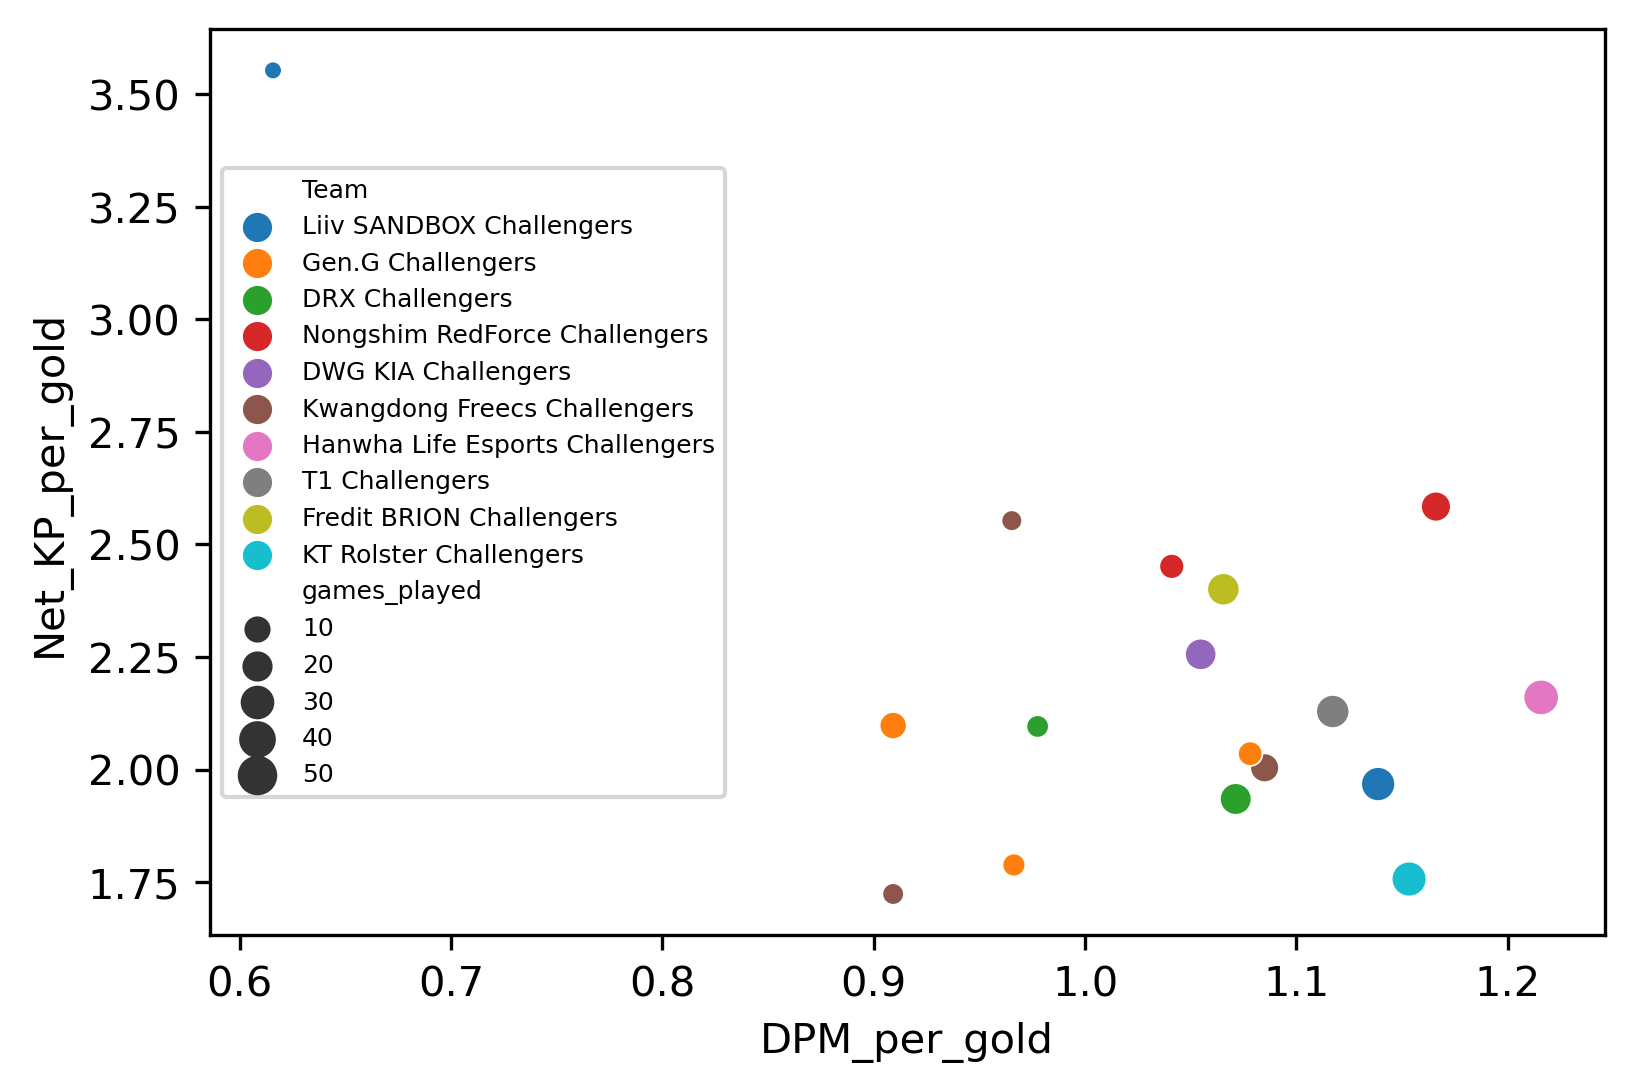

In [ ]:
fig, ax = plt.subplots(1, 1)

fig.set_dpi(300)

gold_efficiency_plot = sns.scatterplot(ax=ax, x="DPM_per_gold",
 y="Net_KP_per_gold", data=agg_all.query('position == "Middle"'),
  hue='Team', size='games_played')
  
  
gold_efficiency_plot.legend(loc='center left', prop={'size': 6})
